In [2]:
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.autograd import Variable
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import os
import cv2                  # pip install opencv-python
from PIL import Image
from tqdm import tqdm_notebook as tqdm  # pip install tqdm
import random
from matplotlib import pyplot as plt
import time
import copy
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### 모델 설계

In [3]:
class VGG(nn.Module):
    def __init__(self, features, output_dim):
        super().__init__()        
        self.features = features        
        self.avgpool = nn.AdaptiveAvgPool2d(7)        
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace = True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace = True),
            nn.Dropout(0.5),
            nn.Linear(4096, output_dim),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h

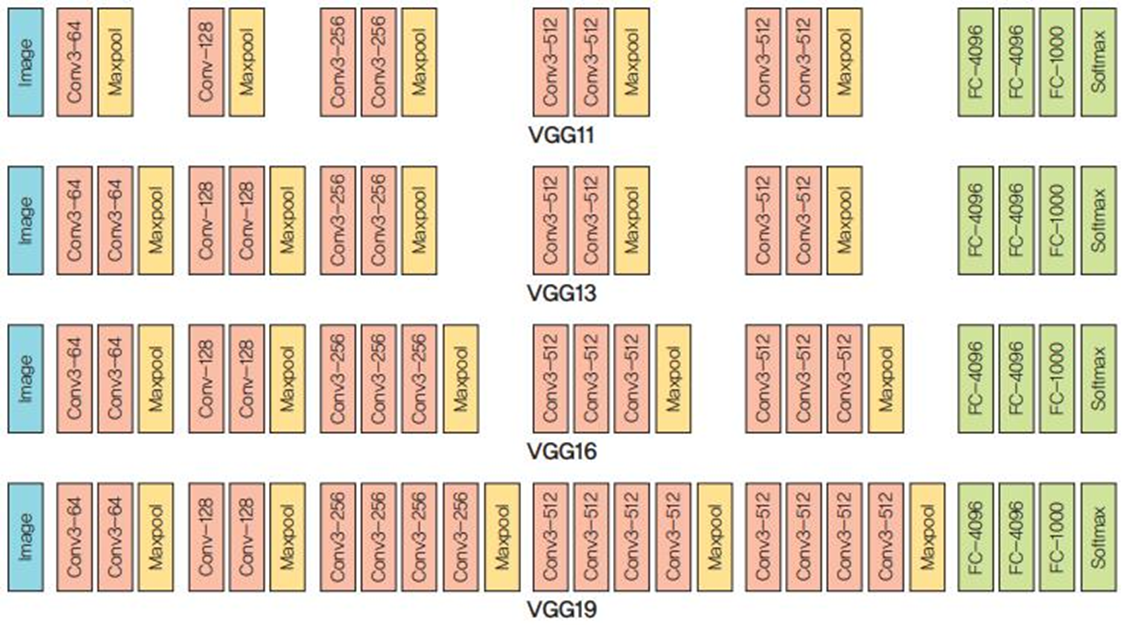

In [4]:
# 버전 마다 깊이가 다르다
vgg11_config = [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

vgg13_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

vgg16_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 
                512, 'M']

vgg19_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 
                512, 512, 512, 512, 'M']

In [5]:
def get_vgg_layers(config, batch_norm):    
    layers = []
    in_channels = 3
    
    for c in config:
        assert c == 'M' or isinstance(c, int) # config안의 값은 숫자거나 'M'이어야 하니 아니면 중단
        if c == 'M':
            layers += [nn.MaxPool2d(kernel_size = 2)]
        else:
            # in_channel은 앞의 out_channel값, out_channel은 c값(해당 순서의 채널 수)
            # kernel = 3, padding = 1로 하면 이미지 크기는 유지
            conv2d = nn.Conv2d(in_channels, c, kernel_size = 3, padding = 1) 

            if batch_norm: # bactch_norm을 넣는다면 
                layers += [conv2d, nn.BatchNorm2d(c), nn.ReLU(inplace = True)]
            else:
                layers += [conv2d, nn.ReLU(inplace = True)]
            in_channels = c
            
    return nn.Sequential(*layers) # list에 있는 것을 풀어서 Sequential을 구성

In [6]:
vgg11_layers = get_vgg_layers(vgg11_config, batch_norm = True)
# vgg13_layers = get_vgg_layers(vgg13_config, batch_norm = True) # 13을 가져오고 싶으면

In [7]:
print(vgg11_layers)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU(inplace=True)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU(inplace=True)
  (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU(inplace=True)
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

In [13]:
OUTPUT_DIM = 2  # 개와 고양이 2개만 구분하니
model = VGG(vgg11_layers, OUTPUT_DIM)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [ ]:
# 아래의 코드를 사용해서 전이학습된 vgg를 불러와서 사용할 수 있다

# import torchvision.models as models
# pretrained_model = models.vgg11_bn(pretrained = True) # 전이학습
# print(pretrained_model)

### 데이터셋 로드

In [14]:
class ImageTransform():    
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            'val': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }
        
    def __call__(self, img, phase):
        return self.data_transform[phase](img)

In [15]:
cat_directory = r'data/dogs-vs-cats/Cat/'
dog_directory = r'data/dogs-vs-cats/Dog/'

# cat_directory에 있는 각각의 사진들 앞에 cat_directory 경로를 붙이고 sorting을 한다
cat_images_filepaths = sorted([os.path.join(cat_directory, f) for f in os.listdir(cat_directory)])   
dog_images_filepaths = sorted([os.path.join(dog_directory, f) for f in os.listdir(dog_directory)])

# 리스트의 unpacking: *, 딕셔너리의 unpacking: **
images_filepaths = [*cat_images_filepaths, *dog_images_filepaths]    

# 제대로 읽어올 수 있는 사진만 선택하는 부분
correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]    

random.seed(42)    
random.shuffle(correct_images_filepaths) # 섞어준다

# 총 500개의 데이터 중 400개는 train, 90개는 val, 10개는 test로 사용했다
train_images_filepaths = correct_images_filepaths[:400]    
val_images_filepaths = correct_images_filepaths[400:-10]  
test_images_filepaths = correct_images_filepaths[-10:]    
print(len(train_images_filepaths), len(val_images_filepaths), len(test_images_filepaths))

400 92 10


In [16]:
class DogvsCatDataset(Dataset):    
    def __init__(self, file_list, transform=None, phase='train'):    
        self.file_list = file_list
        self.transform = transform
        self.phase = phase
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):        
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img, self.phase)
        
        label = img_path.split('/')[-1].split('.')[0]
        if label == 'dog':
            label = 1
        elif label == 'cat':
            label = 0

        return img_transformed, label

In [17]:
size = 256
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32

In [18]:
train_dataset = DogvsCatDataset(train_images_filepaths, transform=ImageTransform(size, mean, std), phase='train')
val_dataset = DogvsCatDataset(val_images_filepaths, transform=ImageTransform(size, mean, std), phase='val')
test_dataset = DogvsCatDataset(val_images_filepaths, transform=ImageTransform(size, mean, std), phase='val')

index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

torch.Size([3, 256, 256])
0


In [19]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
dataloader_dict = {'train': train_dataloader, 'val': val_dataloader}

batch_iterator = iter(train_dataloader)
inputs, label = next(batch_iterator)
print(inputs.size())
print(label)

torch.Size([32, 3, 256, 256])
tensor([0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0,
        1, 0, 1, 0, 0, 0, 1, 1])


In [20]:
optimizer = optim.Adam(model.parameters(), lr = 1e-7)
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [21]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum() # view_as(other) == view(other.size())
                                                     # y.view_as(top_pred)는 y에 대한 텐서 크기를 top_pred의 텐서 크기로 변경
                                                     # sum으로 해서 예측과 정답이 일치하는 것들의 개수를 합산
    acc = correct.float() / y.shape[0]
    return acc

In [22]:
def train(model, iterator, optimizer, criterion, device):    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()    
    for (x, y) in iterator:        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()                
        y_pred, _ = model(x)        
        loss = criterion(y_pred, y)       
        acc = calculate_accuracy(y_pred, y)        
        loss.backward()        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [23]:
def evaluate(model, iterator, criterion, device):    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()    
    with torch.no_grad():        
        for (x, y) in iterator:
            x = x.to(device)
            y = y.to(device)
            y_pred, _ = model(x)
            loss = criterion(y_pred, y)
            acc = calculate_accuracy(y_pred, y)
            epoch_loss += loss.item()
            epoch_acc += acc.item()        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [24]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [25]:
EPOCHS = 5
best_valid_loss = float('inf')
for epoch in range(EPOCHS):    
    start_time = time.monotonic()    
    train_loss, train_acc = train(model, train_dataloader, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, val_dataloader, criterion, device)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'data/VGG-model.pt')

    end_time = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Valid. Loss: {valid_loss:.3f} |  Valid. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 2m 45s
	Train Loss: 0.711 | Train Acc: 48.56%
	 Valid. Loss: 0.693 |  Valid. Acc: 48.81%
Epoch: 02 | Epoch Time: 2m 45s
	Train Loss: 0.703 | Train Acc: 48.32%
	 Valid. Loss: 0.694 |  Valid. Acc: 50.89%
Epoch: 03 | Epoch Time: 2m 50s
	Train Loss: 0.690 | Train Acc: 53.61%
	 Valid. Loss: 0.692 |  Valid. Acc: 53.27%
Epoch: 04 | Epoch Time: 2m 49s
	Train Loss: 0.697 | Train Acc: 47.12%
	 Valid. Loss: 0.686 |  Valid. Acc: 60.86%
Epoch: 05 | Epoch Time: 2m 48s
	Train Loss: 0.685 | Train Acc: 54.81%
	 Valid. Loss: 0.684 |  Valid. Acc: 60.71%


In [26]:
model.load_state_dict(torch.load('data/VGG-model.pt'))
test_loss, test_acc = evaluate(model, test_dataloader, criterion, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.684 | Test Acc: 60.71%


In [27]:
def get_predictions(model, iterator):
    model.eval()
    images = []
    labels = []
    probs = []
    
    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)
            y_pred, _ = model(x)
            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True) # (axis=) 1로 열을 따라 가장 큰 값의 색인을 찾음
                                                        # keepdim으로 출력 텐서를 입력과 동일한 크기로 유지
            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)
    return images, labels, probs

In [28]:
images, labels, probs = get_predictions(model, test_dataloader)
pred_labels = torch.argmax(probs, 1)
corrects = torch.eq(labels, pred_labels) # eq로 서로 같은지 비교
correct_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if correct:
        correct_examples.append((image, label, prob))

correct_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)

In [29]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max) # 주어진 최소, 최대의 범주에 이미지가 위치하도록
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

In [40]:
def plot_most_correct(correct, classes, n_images, normalize = True):
    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))
    fig = plt.figure(figsize = (25, 20))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)        
        image, true_label, probs = correct[i]
        image = image.permute(1, 2, 0)
        true_prob = probs[true_label]
        correct_prob, correct_label = torch.max(probs, dim = 0)
        true_class = classes[true_label]
        correct_class = classes[correct_label]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.cpu().numpy())
        ax.set_title(f'true label: {true_class} ({true_prob:.3f})\n' \
                     f'pred label: {correct_class} ({correct_prob:.3f})')
        ax.axis('off')
        
    fig.subplots_adjust(hspace = 0.4)

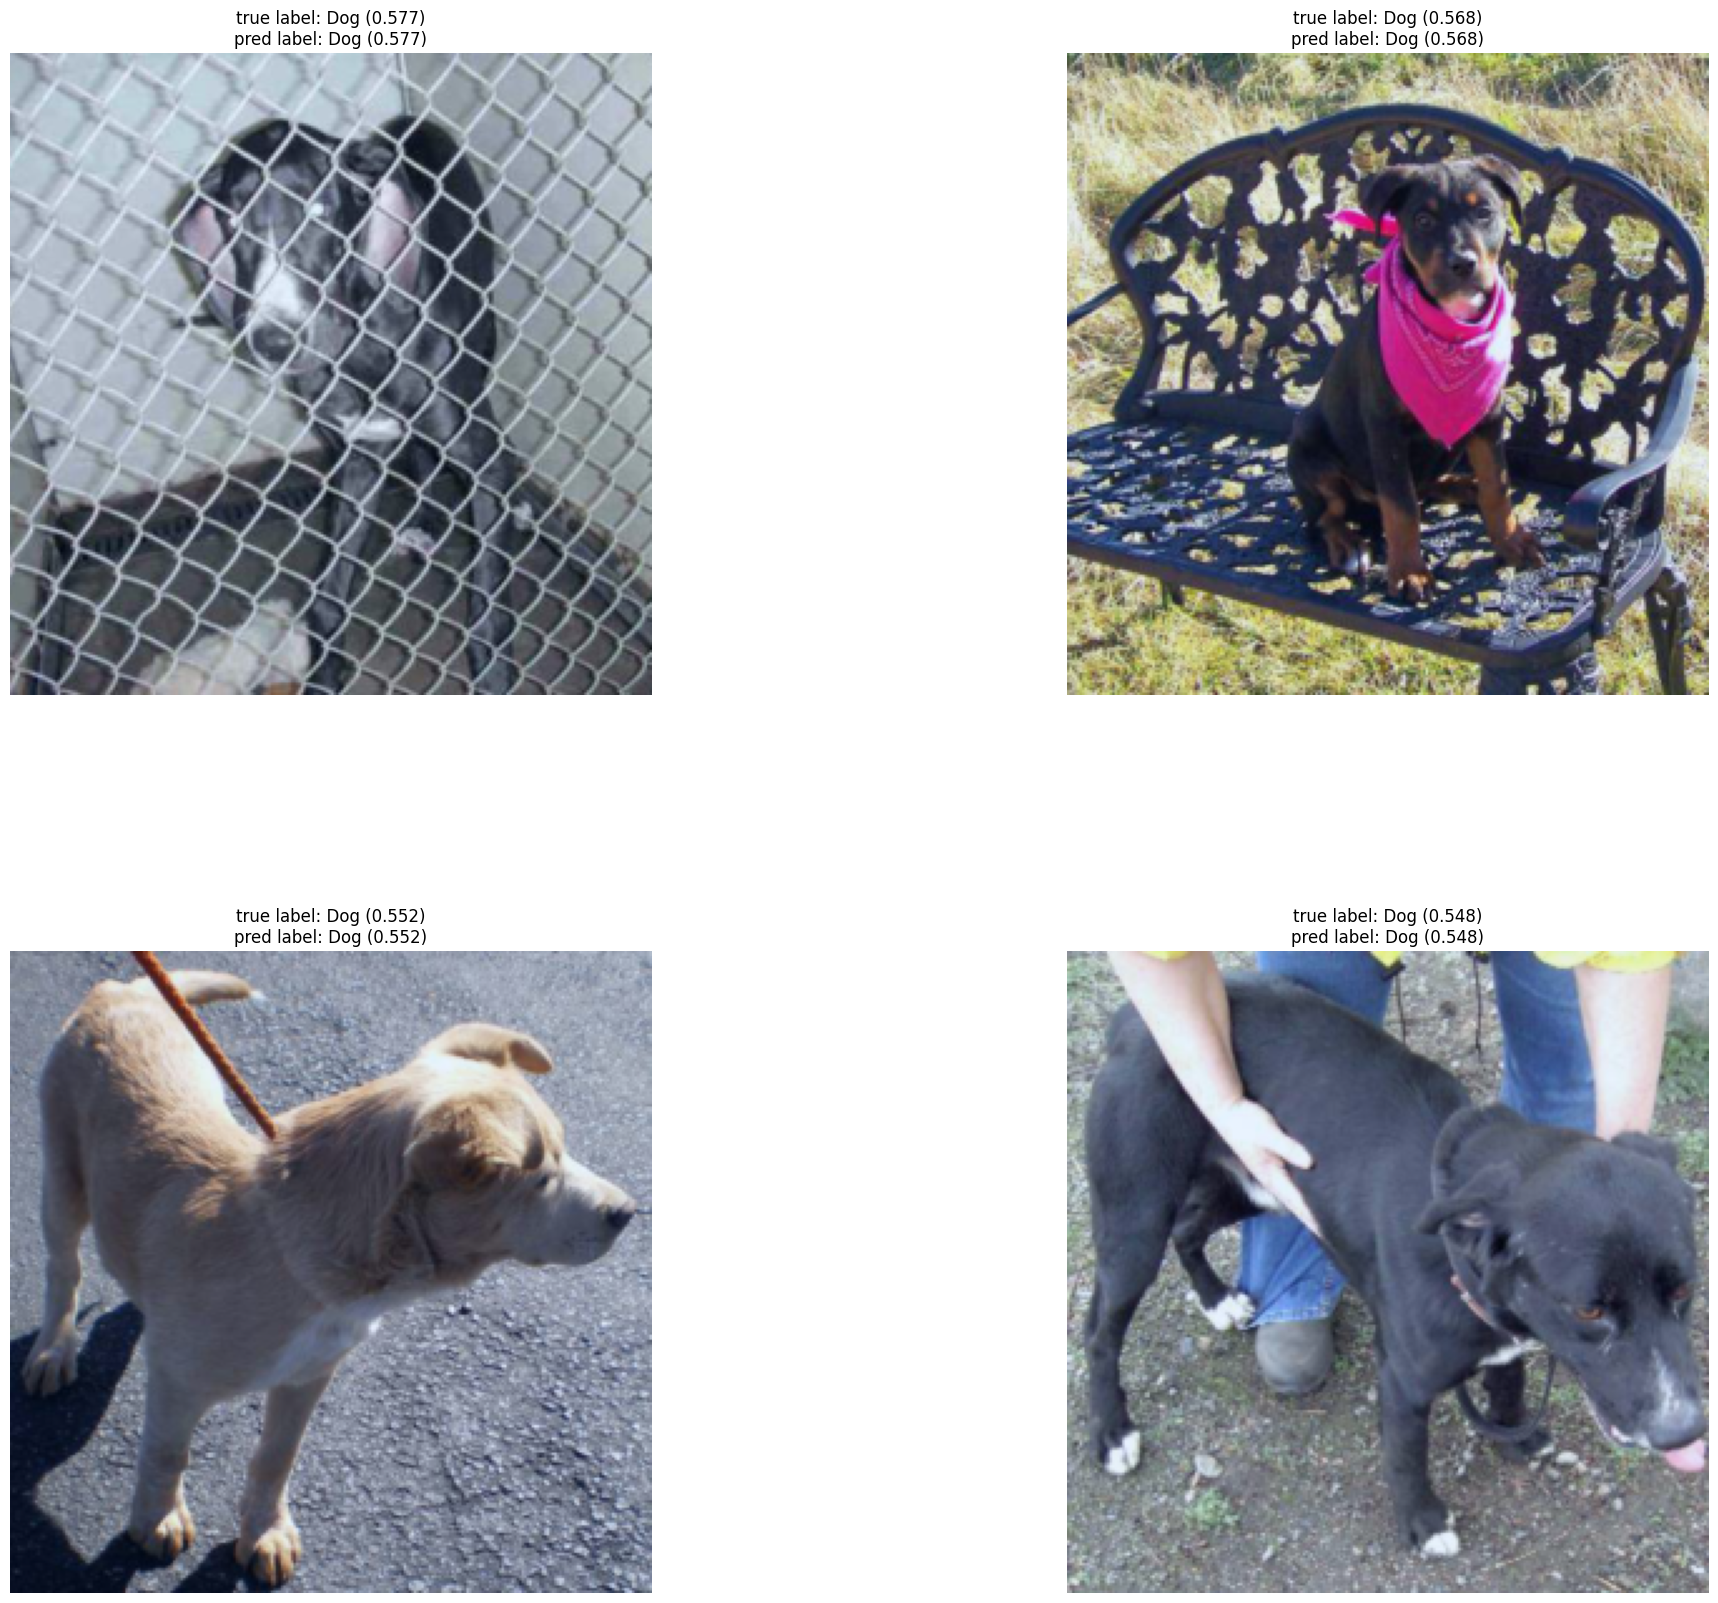

In [41]:
#classes = test_dataset.classes --> torchvision.datasets.ImageFolder로 dataset을 구성한 경우
classes = ['Cat', 'Dog']
N_IMAGES = 5
plot_most_correct(correct_examples, classes, N_IMAGES)